# Predicting Job Chances after Bootcamp
My goal for this project is to be able to predict if a bootcamp participant is able to get a developer job afterwards.

## Exploring the Data

In [656]:
# Import libraries
import numpy as np
import pandas as pd
from time import time
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn.metrics import f1_score

# Read student data
student_data = pd.read_csv("2016-FCC-New-Coders-Survey-Data.csv", low_memory = False)
print "Student data read successfully!"
student_data.shape

Student data read successfully!


(15620, 113)

Let's take a look at the gender distribution of the whole survey.

In [657]:
student_data['Genders'] = student_data.Gender.copy()
student_data.loc[student_data.Genders.isin(['genderqueer', 'trans', 'agender']) | student_data.Genders.isnull(), 
       'Genders'] = 'other/NA'

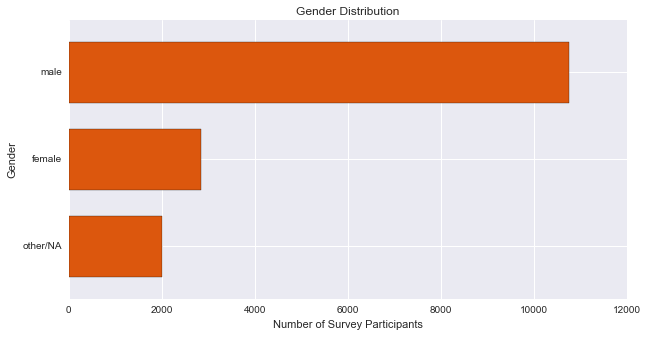

In [658]:
ax = student_data.Genders.value_counts(ascending=True).plot(kind='barh', width=0.7, figsize=(10,5), color='#dc570d')
_ = (ax.set_title('Gender Distribution'),
     ax.set_xlabel('Number of Survey Participants'),
     ax.set_ylabel('Gender'))

Let's take a look at the data of students who attended a bootcamp and finished it. It is also important to only have participants who answered the question, if they got a job or not.

In [659]:
student_data = student_data[(student_data['AttendedBootcamp'] == 1) & (student_data['BootcampFinish'] == 1)]
student_data = student_data.dropna(subset = ['BootcampFullJobAfter'])

Let's see how many bootcamp participants we have information on, and learn about the job success rate among those.

In [660]:
# TODO: Calculate number of students who did or did not get a job after a bootcamp
n_students = student_data.shape[0]

# TODO: Calculate number of features, -1 to not calculate the target column
n_features = student_data.shape[1] - 1

# TODO: Calculate passing students
n_success = student_data[student_data['BootcampFullJobAfter'] == 1].shape[0]

# TODO: Calculate failing students
n_failed = n_students - n_success

# TODO: Calculate graduation rate
success_rate = n_success * 100.0 / n_students

# Print the results
print "Total number of participants: {}".format(n_students)
print "Number of features: {}".format(n_features)
print "Number of participants who got a job: {}".format(n_success)
print "Number of participants who failed to get a job: {}".format(n_failed)
print "Job success rate of bootcamp participants: {:.2f}%".format(success_rate)

Total number of participants: 635
Number of features: 113
Number of participants who got a job: 371
Number of participants who failed to get a job: 264
Job success rate of bootcamp participants: 58.43%


Let's take a look at the gender distribution among bootcamp finishers and those who got a job afterwards.

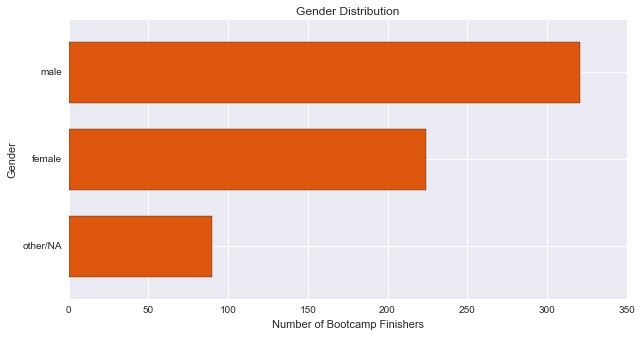

In [661]:
ax = student_data.Genders.value_counts(ascending=True).plot(kind='barh', width=0.7, figsize=(10,5), color='#dc570d')
_ = (ax.set_title('Gender Distribution'),
     ax.set_xlabel('Number of Bootcamp Finishers'),
     ax.set_ylabel('Gender'))

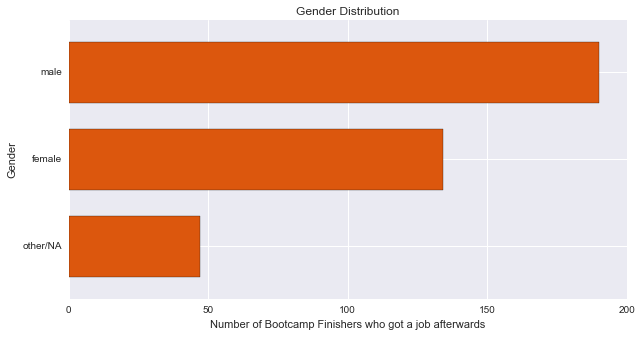

In [662]:
ax = student_data[student_data['BootcampFullJobAfter'] == 1].Genders.value_counts(ascending=True).plot(kind='barh', width=0.7, figsize=(10,5), color='#dc570d')
_ = (ax.set_title('Gender Distribution'),
     ax.set_xlabel('Number of Bootcamp Finishers who got a job afterwards'),
     ax.set_ylabel('Gender'))

Let's see how many bootcamp finishers are working as software developers.

In [663]:
software_dev = student_data[student_data['IsSoftwareDev'] == 1].shape[0]
non_software_dev = student_data[student_data['IsSoftwareDev'] == 0].shape[0]

# Print the results
print "Total number of participants working in Software Developement: {}".format(software_dev)
print "Total number of participants not working in Software Developement: {}".format(non_software_dev)
print "Percentage of participants working in Software Developement: {}".format(software_dev * 100. / (non_software_dev + software_dev))
print "Percentage of participants not working in Software Developement: {}".format(non_software_dev * 100. / (non_software_dev + software_dev))

Total number of participants working in Software Developement: 384
Total number of participants not working in Software Developement: 251
Percentage of participants working in Software Developement: 60.4724409449
Percentage of participants not working in Software Developement: 39.5275590551


## Preparing the Data
### Identify feature and target columns
Let's have a look at the feature columns we have. We'll use `'BootcampFullJobAfter'` as the target column.

In [664]:
# Extract feature columns
feature_cols = list(student_data.columns[:3]) + list(student_data.columns[4:])

# Extract target column 'passed'
target_col = student_data.columns[3] 

# Show the list of columns
print "Feature columns:\n{}".format(feature_cols)
print "\nTarget column: {}".format(target_col)

Feature columns:
['Age', 'AttendedBootcamp', 'BootcampFinish', 'BootcampLoanYesNo', 'BootcampMonthsAgo', 'BootcampName', 'BootcampPostSalary', 'BootcampRecommend', 'ChildrenNumber', 'CityPopulation', 'CodeEventBootcamp', 'CodeEventCoffee', 'CodeEventConferences', 'CodeEventDjangoGirls', 'CodeEventGameJam', 'CodeEventGirlDev', 'CodeEventHackathons', 'CodeEventMeetup', 'CodeEventNodeSchool', 'CodeEventNone', 'CodeEventOther', 'CodeEventRailsBridge', 'CodeEventRailsGirls', 'CodeEventStartUpWknd', 'CodeEventWomenCode', 'CodeEventWorkshop', 'CommuteTime', 'CountryCitizen', 'CountryLive', 'EmploymentField', 'EmploymentFieldOther', 'EmploymentStatus', 'EmploymentStatusOther', 'ExpectedEarning', 'FinanciallySupporting', 'Gender', 'HasChildren', 'HasDebt', 'HasFinancialDependents', 'HasHighSpdInternet', 'HasHomeMortgage', 'HasServedInMilitary', 'HasStudentDebt', 'HomeMortgageOwe', 'HoursLearning', 'ID.x', 'ID.y', 'Income', 'IsEthnicMinority', 'IsReceiveDiabilitiesBenefits', 'IsSoftwareDev', 'Is

To make reasonable predictions, we have to drop some columns which contain information we wouldn't have, if the person is still attending the bootcamp. We also drop the columns `'AttendedBootcamp'` and `'BootcampFinish'`, because we only look at students who answered those questions with `yes`.

We also get rid of the `'ID.x'`, `'ID.y'`, `'NetworkID'`, `'Part1EndTime'`, `'Part1StartTime'`, `'Part2EndTime'`and `'Part2StartTime'` features, because they are unique to each individual student and don't help with the prediction.

In [665]:
features_to_remove = ['AttendedBootcamp', 'BootcampFinish', 'BootcampMonthsAgo', 'BootcampPostSalary', 'BootcampRecommend', 'ID.x', 'ID.y', 'NetworkID', 'Part1EndTime', 'Part1StartTime', 'Part2EndTime', 'Part2StartTime', 'IsSoftwareDev']

for ftr in features_to_remove:
    feature_cols.remove(ftr)

Let's have a look on the data.

In [666]:
student_data[feature_cols].head()

,Age,BootcampLoanYesNo,BootcampName,ChildrenNumber,CityPopulation,CodeEventBootcamp,CodeEventCoffee,CodeEventConferences,CodeEventDjangoGirls,CodeEventGameJam,...,ResourceStackOverflow,ResourceTreehouse,ResourceUdacity,ResourceUdemy,ResourceW3Schools,ResourceYouTube,SchoolDegree,SchoolMajor,StudentDebtOwe,Genders
93,32.0,0.0,Codify Academy,NaN,"between 100,000 and 1 million",NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,1.0,NaN,NaN,NaN,bachelor's degree,Biology,NaN,male
97,26.0,0.0,DaVinci Coders,NaN,more than 1 million,NaN,NaN,1.0,NaN,NaN,...,NaN,NaN,NaN,1.0,NaN,NaN,master's degree (non-professional),Music,80000.0,male
130,41.0,1.0,Coder Foundry,3.0,"less than 100,000",NaN,1.0,1.0,NaN,NaN,...,NaN,NaN,NaN,1.0,NaN,NaN,"some college credit, no degree",NaN,8000.0,male
159,26.0,0.0,General Assembly,NaN,"between 100,000 and 1 million",NaN,1.0,1.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,"some college credit, no degree",NaN,NaN,female
206,36.0,0.0,Thinkful,2.0,more than 1 million,NaN,1.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,bachelor's degree,Communications,NaN,female


We have a lot of cells with no value. That's probably because the people filling out the survey could decide which questions they choose to answer or because all 0 and no are displayed as `NaN`.

Especially in questions where the answers are `yes` or `no`, we have the values 1.0 or `NaN`.

Let's take a quick look if we have the value 0 in the category `'StudentDebtOwe'`, or if all 0 values are `NaN`.

In [667]:
student_data[student_data['StudentDebtOwe'] == 0]

,Age,AttendedBootcamp,BootcampFinish,BootcampFullJobAfter,BootcampLoanYesNo,BootcampMonthsAgo,BootcampName,BootcampPostSalary,BootcampRecommend,ChildrenNumber,...,ResourceStackOverflow,ResourceTreehouse,ResourceUdacity,ResourceUdemy,ResourceW3Schools,ResourceYouTube,SchoolDegree,SchoolMajor,StudentDebtOwe,Genders


It seems there is value 0. This means it's pretty safe to fill the missing values with 0.

In [668]:
student_data = student_data.fillna(0)

In [669]:
# Separate the data into feature data and target data (X_all and y_all, respectively)
X_all = student_data[feature_cols]
y_all = student_data[target_col]

### Preprocess Feature Columns
Most machine learning algorithms expect numeric data. Let's see if we have any non-numeric features.

In [670]:
# Show the feature information by printing the first five rows
print "\nFeature values:"
print X_all.head()


Feature values:
      Age  BootcampLoanYesNo      BootcampName  ChildrenNumber  \
93   32.0                0.0    Codify Academy             0.0   
97   26.0                0.0    DaVinci Coders             0.0   
130  41.0                1.0     Coder Foundry             3.0   
159  26.0                0.0  General Assembly             0.0   
206  36.0                0.0          Thinkful             2.0   

                    CityPopulation  CodeEventBootcamp  CodeEventCoffee  \
93   between 100,000 and 1 million                0.0              0.0   
97             more than 1 million                0.0              0.0   
130              less than 100,000                0.0              1.0   
159  between 100,000 and 1 million                0.0              1.0   
206            more than 1 million                0.0              1.0   

     CodeEventConferences  CodeEventDjangoGirls  CodeEventGameJam   ...     \
93                    0.0                   0.0               0

There are several binary values. This seems fine after replacing all `NaN` with zeros. We still have some non-numeric columns. These are known as categorical variables.

To handle the categorcial variables, I create as many columns as possible values and fill these with binary values.

In [671]:
def preprocess_features(X):
    ''' Preprocesses the student data and converts non-numeric categorical variables into dummy variables. '''
    
    # Initialize new output DataFrame
    output = pd.DataFrame(index = X.index)

    # Investigate each feature column for the data
    for col, col_data in X.iteritems():

        # If data type is categorical, convert to dummy variables
        if col_data.dtype == object:
            # Example: 'SchoolMajor' => 'SchoolMajor_Accounting', 'SchoolMajor_Acting', ...
            col_data = pd.get_dummies(col_data, prefix = col)  
        
        # Collect the revised columns
        output = output.join(col_data)
    
    return output

X_all = preprocess_features(X_all)
print "Processed feature columns ({} total features):\n{}".format(len(X_all.columns), list(X_all.columns))

Processed feature columns (734 total features):
['Age', 'BootcampLoanYesNo', 'BootcampName_0', 'BootcampName_10x.org.il', 'BootcampName_4Geeks Academy', 'BootcampName_AcadGild', 'BootcampName_Academia de C\xc3\xb3digo', 'BootcampName_Academy X', 'BootcampName_Ada', 'BootcampName_Anyone Can Learn To Code', 'BootcampName_App Academy', 'BootcampName_Atlanta Code', 'BootcampName_Austin Coding Academy', 'BootcampName_Big Nerd Ranch', 'BootcampName_Bit Bootcamp', 'BootcampName_Bitmaker Labs', 'BootcampName_Bloc.io', 'BootcampName_BoiseCodeWorks', 'BootcampName_BrainStation', 'BootcampName_CODEcamp Charleston', 'BootcampName_Camp Code Away', 'BootcampName_CareerFoundry', 'BootcampName_Code Fellows', 'BootcampName_Code For Progress', 'BootcampName_CodeCore Bootcamp', 'BootcampName_CodeaCamp', 'BootcampName_Codecademy Labs', 'BootcampName_Coder Camps', 'BootcampName_Coder Foundry', "BootcampName_Coder's Lab", 'BootcampName_Codesmith', 'BootcampName_Codeup', 'BootcampName_Codify Academy', 'Bootc

Let's take a look at some statistics.

In [672]:
student_data.describe()

,Age,AttendedBootcamp,BootcampFinish,BootcampFullJobAfter,BootcampLoanYesNo,BootcampMonthsAgo,BootcampPostSalary,BootcampRecommend,ChildrenNumber,CodeEventBootcamp,...,ResourceReddit,ResourceSkillCrush,ResourceSoloLearn,ResourceStackOverflow,ResourceTreehouse,ResourceUdacity,ResourceUdemy,ResourceW3Schools,ResourceYouTube,StudentDebtOwe
count,635.000000,635.0,635.0,635.000000,635.000000,635.000000,635.000000,635.000000,635.000000,635.000000,...,635.0,635.000000,635.0,635.000000,635.000000,635.000000,635.000000,635.0,635.000000,635.000000
mean,27.166929,1.0,1.0,0.584252,0.344882,8.886614,33124.987402,0.748031,0.335433,0.025197,...,0.0,0.001575,0.0,0.007874,0.055118,0.187402,0.311811,0.0,0.001575,10691.428346
std,13.262950,0.0,0.0,0.493239,0.475704,12.932721,37093.998124,0.434486,1.015303,0.156846,...,0.0,0.039684,0.0,0.088455,0.228391,0.390541,0.463598,0.0,0.039684,34778.262233
min,0.000000,1.0,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000
25%,24.000000,1.0,1.0,0.000000,0.000000,3.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000
50%,28.000000,1.0,1.0,1.000000,0.000000,6.000000,15000.000000,1.000000,0.000000,0.000000,...,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000
75%,34.000000,1.0,1.0,1.000000,1.000000,12.000000,60000.000000,1.000000,0.000000,0.000000,...,0.0,0.000000,0.0,0.000000,0.000000,0.000000,1.000000,0.0,0.000000,10000.000000
max,60.000000,1.0,1.0,1.000000,1.000000,220.000000,200000.000000,1.000000,15.000000,1.000000,...,0.0,1.000000,0.0,1.000000,1.000000,1.000000,1.000000,0.0,1.000000,675856.000000


In [673]:
no_job = student_data[student_data['BootcampFullJobAfter'] == 0]
with pd.option_context('display.max_rows', 999, 'display.max_columns', 90):
    print no_job.describe()

              Age  AttendedBootcamp  BootcampFinish  BootcampFullJobAfter  \
count  264.000000             264.0           264.0                 264.0   
mean    28.715909               1.0             1.0                   0.0   
std     15.138109               0.0             0.0                   0.0   
min      0.000000               1.0             1.0                   0.0   
25%     25.000000               1.0             1.0                   0.0   
50%     30.000000               1.0             1.0                   0.0   
75%     37.000000               1.0             1.0                   0.0   
max     60.000000               1.0             1.0                   0.0   

       BootcampLoanYesNo  BootcampMonthsAgo  BootcampPostSalary  \
count         264.000000         264.000000               264.0   
mean            0.348485           6.125000                 0.0   
std             0.477395           6.626045                 0.0   
min             0.000000           0.0

In [674]:
got_job = student_data[student_data['BootcampFullJobAfter'] == 1]
with pd.option_context('display.max_rows', 999, 'display.max_columns', 90):
    print got_job.describe()

              Age  AttendedBootcamp  BootcampFinish  BootcampFullJobAfter  \
count  371.000000             371.0           371.0                 371.0   
mean    26.064690               1.0             1.0                   1.0   
std     11.644561               0.0             0.0                   0.0   
min      0.000000               1.0             1.0                   1.0   
25%     24.000000               1.0             1.0                   1.0   
50%     27.000000               1.0             1.0                   1.0   
75%     31.000000               1.0             1.0                   1.0   
max     57.000000               1.0             1.0                   1.0   

       BootcampLoanYesNo  BootcampMonthsAgo  BootcampPostSalary  \
count         371.000000         371.000000          371.000000   
mean            0.342318          10.851752        56696.407008   
std             0.475126          15.686700        31901.526147   
min             0.000000           0.0

###  Training and Testing Data Split
I use a test set with 25 % of the original data.

In [675]:
from sklearn.cross_validation import train_test_split

# TODO: Shuffle and split the dataset into the number of training and testing points above
X_train, X_test, y_train, y_test = train_test_split(X_all, y_all, test_size = 0.25, random_state = 42)

# Show the results of the split
print "Training set has {} samples.".format(X_train.shape[0])
print "Testing set has {} samples.".format(X_test.shape[0])

Training set has 476 samples.
Testing set has 159 samples.


## Training and Evaluating Model

Reusing some functions from the project "student_intervention_system" (https://jannab.github.io/student_intervention/) to measure performance of the algorithm.

In [676]:
def train_classifier(clf, X_train, y_train):
    ''' Fits a classifier to the training data. '''
    
    # Start the clock, train the classifier, then stop the clock
    start = time()
    clf.fit(X_train, y_train)
    end = time()
    
    # Print the results
    print "Trained model in {:.4f} seconds".format(end - start)

    
def predict_labels(clf, features, target):
    ''' Makes predictions using a fit classifier based on F1 score. '''
    
    # Start the clock, make predictions, then stop the clock
    start = time()
    y_pred = clf.predict(features)
    end = time()
    
    # Print and return results
    print "Made predictions in {:.4f} seconds.".format(end - start)
    return f1_score(target.values, y_pred, pos_label=1.)


def train_predict(clf, X_train, y_train, X_test, y_test):
    ''' Train and predict using a classifer based on F1 score. '''
    
    # Indicate the classifier and the training set size
    print "Training a {} using a training set size of {}. . .".format(clf.__class__.__name__, len(X_train))
    
    # Train the classifier
    train_classifier(clf, X_train, y_train)
    
    # Print the results of prediction for both training and testing
    print "F1 score for training set: {:.4f}.".format(predict_labels(clf, X_train, y_train))
    print "F1 score for test set: {:.4f}.".format(predict_labels(clf, X_test, y_test))

In [677]:
# Import needed ML algorithm
from sklearn.ensemble import RandomForestClassifier

# Initialize the classifier
clf = RandomForestClassifier(random_state=42)

# Execute the 'train_predict' function for the classifier
train_predict(clf, X_train, y_train, X_test, y_test)

Training a RandomForestClassifier using a training set size of 476. . .
Trained model in 0.0262 seconds
Made predictions in 0.0015 seconds.
F1 score for training set: 0.9873.
Made predictions in 0.0009 seconds.
F1 score for test set: 0.8808.


In [678]:
# Import 'gridSearchCV' and 'make_scorer'
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import make_scorer

# TODO: Create the parameters list you wish to tune
parameters = {'min_samples_split': range(5,200,5)}

# TODO: Initialize the classifier
clf = RandomForestClassifier(random_state=42)

# TODO: Make an f1 scoring function using 'make_scorer' 
f1_scorer = make_scorer(f1_score,pos_label=1.)

# TODO: Perform grid search on the classifier using the f1_scorer as the scoring method
grid_obj = GridSearchCV(clf, parameters, scoring = f1_scorer)

# TODO: Fit the grid search object to the training data and find the optimal parameters
grid_obj = grid_obj.fit(X_train, y_train)

# Get the estimator
clf = grid_obj.best_estimator_

# Report the final F1 score for training and testing after parameter tuning
print "Tuned model has a training F1 score of {:.4f}.".format(predict_labels(clf, X_train, y_train))
print "Tuned model has a testing F1 score of {:.4f}.".format(predict_labels(clf, X_test, y_test))

Made predictions in 0.0011 seconds.
Tuned model has a training F1 score of 0.9018.
Made predictions in 0.0008 seconds.
Tuned model has a testing F1 score of 0.8832.


Let's take a look at the 20 most important features the classifier found.

In [679]:
#for index, importance in enumerate(clf.feature_importances_):
#    if importance > 0:
#        print "{}: {}".format(X_all.columns[index], importance)

print "Features sorted by their score:"
features_sorted = sorted(zip(map(lambda x: round(x, 4), clf.feature_importances_), X_all.columns), 
             reverse=True)[:20]
print features_sorted

Features sorted by their score:
[(0.1462, 'JobRoleInterest_0'), (0.0891, 'JobPref_0'), (0.086, 'ExpectedEarning'), (0.0725, 'CommuteTime'), (0.0559, "JobApplyWhen_I'm already applying"), (0.0554, 'JobWherePref_0'), (0.0523, 'HoursLearning'), (0.0518, 'EmploymentField_software development and IT'), (0.0508, 'EmploymentStatus_Not working but looking for work'), (0.0448, 'JobPref_work for a medium-sized company'), (0.0242, 'MonthsProgramming'), (0.0225, 'JobRoleInterest_Full-Stack Web Developer'), (0.022, 'EmploymentStatus_Employed for wages'), (0.0198, 'Age'), (0.0161, 'JobWherePref_no preference'), (0.0124, 'JobPref_start your own business'), (0.0117, 'JobRelocateYesNo'), (0.0083, 'ResourceCodecademy'), (0.0082, 'JobApplyWhen_0'), (0.0078, 'JobRoleInterest_Back-End Web Developer')]


Let's see the mean value of `'IsSoftwareDev'` for those who got a job after finishing a bootcamp.

In [680]:
student_data[student_data['BootcampFullJobAfter'] == 1]['IsSoftwareDev'].mean()

0.9191374663072777

Because of the high mean value of 0.92, I chose to drop the feature `'IsSoftwareDev'`.

Visualization of the 20 most important features:

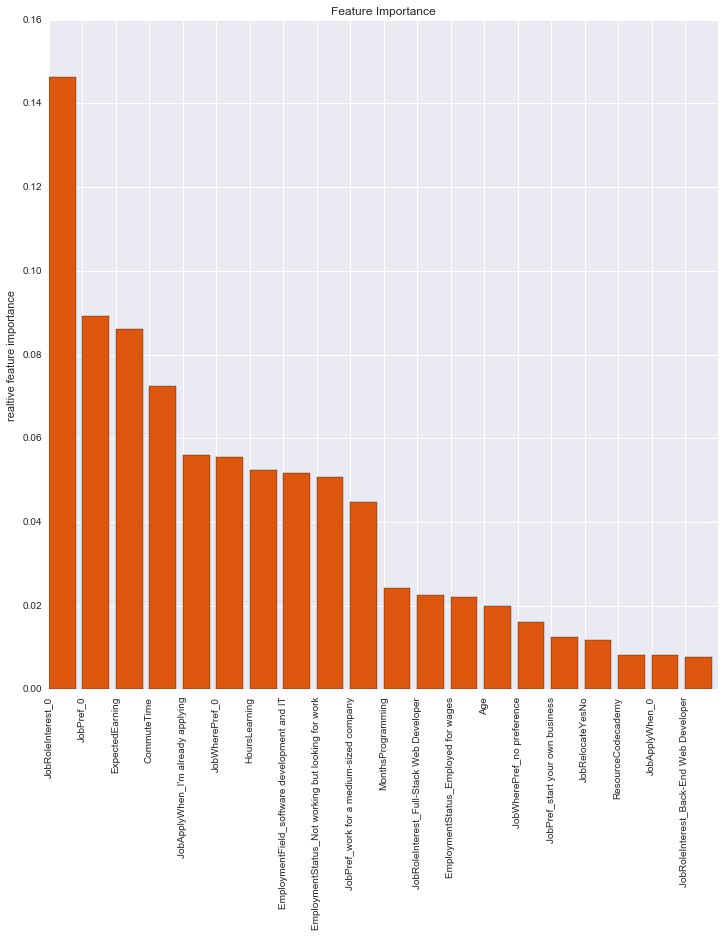

In [681]:
features_sorted_x = []
features_sorted_y = []
labels_x = []

for index, feature in enumerate(features_sorted):
    features_sorted_x.append(index)
    features_sorted_y.append(feature[0])
    labels_x.append(feature[1])

fig = plt.figure(figsize=(12, 12))
plt.bar(features_sorted_x, features_sorted_y, color='#dc570d')
plt.xticks(features_sorted_x, labels_x, rotation=90)
plt.title('Feature Importance')
plt.ylabel('realtive feature importance')
plt.show()